In [129]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import sklearn
import torch

# Uso de acelerador hardare

detectamos y guardamos el device que se corresponde a la tarjeta grafica del ordenador que estamos utilizando.

In [130]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 2060'

# Carga de datos:

## Cargamos el csv

In [131]:
path = "./data/flechas/dataset_cleaned.csv"

In [132]:
df = pd.read_csv(
    path,
    sep="\t",
    names=["path", "angle"]
)

df["sin"] =  np.sin(df.angle * 2 * np.pi)
df["cos"] =  np.cos(df.angle * 2 * np.pi)

df.head(10)

,path,angle,sin,cos
0,dataset/lyrs=y&x=498928&y=388383&z=20-0.png,0.747256,-0.999851,-0.017239
1,dataset/lyrs=y&x=498933&y=388386&z=20-1.png,0.085187,0.510054,0.860142
2,dataset/lyrs=y&x=498934&y=388391&z=20-2.png,0.634782,-0.749204,-0.662340
3,dataset/lyrs=y&x=498934&y=388391&z=20-3.png,0.140102,0.770920,0.636932
4,dataset/lyrs=y&x=498940&y=388395&z=20-4.png,0.887765,-0.648182,0.761485
5,dataset/lyrs=y&x=498940&y=388396&z=20-5.png,0.383562,0.668060,-0.744107
6,dataset/lyrs=y&x=498940&y=388396&z=20-6.png,0.377128,0.697588,-0.716499
7,dataset/lyrs=y&x=498940&y=388396&z=20-7.png,0.889370,-0.640467,0.767985
8,dataset/lyrs=y&x=498941&y=388397&z=20-8.png,0.385122,0.660736,-0.750619
9,dataset/lyrs=y&x=498941&y=388397&z=20-9.png,0.380757,0.681070,-0.732218


a continuacion realizamos el train test split.

In [133]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

## Definimos un dataset personalizado.

Un dataset pytorch se define mediante una clase personalizada. Que debe implementar dos metodos principales que son los siguientes.

- Getitem: 
- len:


### preprocesamiento de imagen.

Para definir el dataset nos apoyaremos en la funcion process(path) que encapsulara todo el preprocesamiento que deseamos hacerle a una imagen.

In [134]:
import torchvision.transforms.functional as F_t
import torchvision.transforms as transforms



def preprocess(path, size=(64, 64)):
    """A priori solo cargamos la imagen y nos aseguramos de que mida 64 x 64"""

    img_path = "data/flechas/" + path
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, size)
    img = F_t.to_tensor(img)

    img = F_t.normalize(
        img,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    return img

In [135]:
# testeamos que el preprocesamiento sea correcto.

processed_img = preprocess(df["path"][227])

print(f"La imagen procesada es de tipo: {type(processed_img)}")
print(f"La imagen procesada tiene un tamao: {processed_img.shape}")
print(f"la imagen tiene valores entre los puntos {processed_img.max().item(), processed_img.min().item()}")

La imagen procesada es de tipo: <class 'torch.Tensor'>
La imagen procesada tiene un tamao: torch.Size([3, 64, 64])
la imagen tiene valores entre los puntos (2.6051416397094727, -1.983193278312683)


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

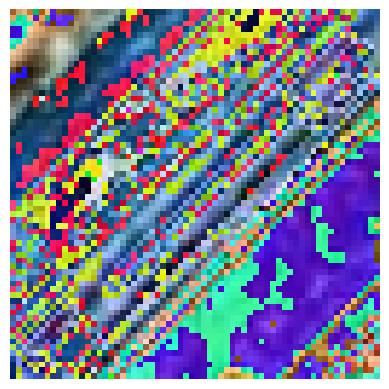

In [136]:
# Vemos que se puede recuperar la imagen original.

processed_img = preprocess(df["path"][227])
remade_img = F_t.to_pil_image(processed_img)
plt.imshow(remade_img)
plt.axis("off")

### Definicion del dataset

In [137]:
from torch.utils.data import Dataset

class ArrowsDS(Dataset):
    def __init__(self, df, size=(64, 64)):
        super().__init__()
        self.size = size
        self.df : pd.DataFrame = df

    def __getitem__(self, index):
        path = self.df.iloc[index, 0]
        img_tensor = preprocess(path, self.size)

        angle_sincos = self.df.iloc[index, 2:].values

        return (
            img_tensor,
            torch.tensor(np.array(angle_sincos, dtype="float32"))
        )

    def __len__(self):
        return len(self.df)

In [138]:
arrows_ds = ArrowsDS(df)

In [139]:
# Comprobamos lo que nos devuelve el dataset cuando lo indexamos.

arrows_ds = ArrowsDS(df)
print([(type(resul), resul.shape) for resul in arrows_ds[0]])

[(<class 'torch.Tensor'>, torch.Size([3, 64, 64])), (<class 'torch.Tensor'>, torch.Size([2]))]


In [140]:
# creamos los datasets de entrenamiento y de test

train_arrows_ds = ArrowsDS(train_df)
test_arrows_ds = ArrowsDS(test_df)

# Creacion del modelo:

In [141]:
from torch import nn
import torch.nn.functional as F_n

class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolution_sequence = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.flatten = nn.Flatten()

        self.linear_sequence = nn.Sequential(
            nn.Linear(in_features=4096, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=2)
        )

    def forward(self, x):
        conv_resul = self.convolution_sequence(x)
        flattened_resul = self.flatten(conv_resul)
        logit = self.linear_sequence(flattened_resul)
        output = F_n.tanh(logit)

        return output

instanciemos la cnn y veamos algunas de sus caracteristicas.

In [142]:
## Vemos un resumen de la rnn que hemos definido.

basecnn = BaseCNN().to(device)
print(basecnn)

BaseCNN(
  (convolution_sequence): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sequence): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU(

In [143]:
# veamos cuantos parametros hay por cada capa de la red:

for name, parameters in basecnn.named_parameters():
    print(f"{name:<30}  {parameters.numel():>10,}")

convolution_sequence.0.weight          432
convolution_sequence.0.bias             16
convolution_sequence.1.weight           16
convolution_sequence.1.bias             16
convolution_sequence.4.weight        4,608
convolution_sequence.4.bias             32
convolution_sequence.5.weight           32
convolution_sequence.5.bias             32
convolution_sequence.8.weight       18,432
convolution_sequence.8.bias             64
convolution_sequence.9.weight           64
convolution_sequence.9.bias             64
linear_sequence.0.weight           524,288
linear_sequence.0.bias                 128
linear_sequence.3.weight               256
linear_sequence.3.bias                   2


Veamos si funciona el fordardpass si le pasamos una imagen cualquiera.

[]

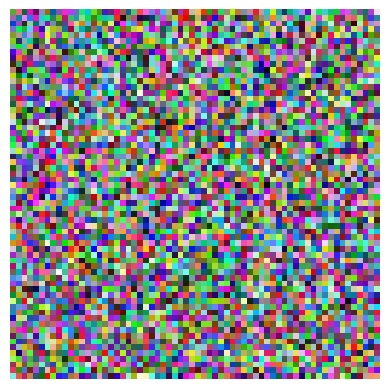

In [144]:
from torchvision.transforms.functional import to_pil_image

randimg_tensor = torch.rand((1 ,3, 64, 64)).to(device)
pil_rand_img = to_pil_image(randimg_tensor.cpu()[0, :, :, :])
plt.imshow(pil_rand_img)
plt.axis("off")
plt.plot()

In [145]:
## Comprobamos que se obtiene un resultado del forward.

basecnn.forward(randimg_tensor)

tensor([[0.1031, 0.1244]], device='cuda:0', grad_fn=<TanhBackward0>)

# Bucle de entrenamiento.

## Definicion de loss y optimicer.

In [146]:

loss = nn.MSELoss()
optimicer = torch.optim.Adam(basecnn.parameters())

### Definimos el dataloader:

In [147]:
from torch.utils.data import DataLoader

train_dl = DataLoader(
    dataset=train_arrows_ds,
    batch_size=8,
    shuffle=True,
)

In [148]:
len(train_df)

6030

### Definimos el bucle de entrenamiento.

In [149]:
test_dl = DataLoader(
    dataset=test_arrows_ds,
    batch_size=8,
    shuffle=True,
)

In [150]:
def non_diferientable_loss(a, b):
     a_sin, a_cos = a
     b_sin, b_cos = b

     angle_a = np.degrees(np.arctan2(a_sin, a_cos)) % 360
     angle_b = np.degrees(np.arctan2(b_sin, b_cos)) % 360

     abs_dif = abs(angle_a - angle_b)

     return min(
          abs_dif,
          360 - abs_dif
)

vectoriced_non_diferientable_loss = np.vectorize(non_diferientable_loss)

In [151]:
def test_error(model, test_dl):
    model.eval()
    ground_truth = []
    pred = []

    for _, (batch_img, ground_truth_batch) in enumerate(test_dl):

        with torch.no_grad():
            ground_truth_batch = ground_truth_batch.to(device)
            batch_img = batch_img.to(device)
            output = model(batch_img).to(device)

            ground_truth.extend(ground_truth_batch.cpu().numpy())
            pred.extend(output.cpu().numpy())

    ground_truth = np.array(ground_truth)
    pred = np.array(pred)

    results = np.mean([non_diferientable_loss(a, b) for a, b in zip(ground_truth, pred)])
    return results


In [152]:
basecnn = BaseCNN().to(device)
optimicer = torch.optim.Adam(basecnn.parameters())
loss = nn.MSELoss()

def train(model, train_dl, test_dl, loss, optimicer, epochs = 10):
    model = model.to(device)
    i = 0
    print_test_error = True

    for epoch in range(epochs):
        for _, (batch_img, ground_truth_batch) in enumerate(train_dl):
            ground_truth_batch = ground_truth_batch.to(device)
            batch_img = batch_img.to(device)
            output = model(batch_img)

            loss_val : torch.Tensor = loss(ground_truth_batch, output)

            optimicer.zero_grad()
            loss_val.backward()
            optimicer.step()

            i += 1

            if i%500 == 0:
                print(f"Epoch: {epoch} - iteracion: {i}")
                if print_test_error:
                    print(f"Loss Train: {loss_val.item()} - Test error: {test_error(model, test_dl)} grados")
                    model.train()
                else:
                    print(f"Loss Train: {loss_val.item()}")

In [153]:
train(basecnn, train_dl, test_dl, loss, optimicer, epochs=16)

Epoch: 0 - iteracion: 500
Loss Train: 0.15672078728675842 - Test error: 41.79145050048828 grados
Epoch: 1 - iteracion: 1000
Loss Train: 0.20625771582126617 - Test error: 34.525672912597656 grados
Epoch: 1 - iteracion: 1500
Loss Train: 0.19025783240795135 - Test error: 33.995121002197266 grados
Epoch: 2 - iteracion: 2000
Loss Train: 0.10865882784128189 - Test error: 32.43008804321289 grados
Epoch: 3 - iteracion: 2500
Loss Train: 0.3541461229324341 - Test error: 30.558671951293945 grados
Epoch: 3 - iteracion: 3000
Loss Train: 0.13135626912117004 - Test error: 29.519073486328125 grados
Epoch: 4 - iteracion: 3500
Loss Train: 0.21517157554626465 - Test error: 27.765100479125977 grados
Epoch: 5 - iteracion: 4000
Loss Train: 0.08154456317424774 - Test error: 27.699201583862305 grados
Epoch: 5 - iteracion: 4500
Loss Train: 0.11349718272686005 - Test error: 25.645483016967773 grados
Epoch: 6 - iteracion: 5000
Loss Train: 0.12914066016674042 - Test error: 26.0 grados
Epoch: 7 - iteracion: 5500
L

# Definimos el bucle de evaluacion:

In [154]:
test_dl = DataLoader(
    dataset=test_arrows_ds,
    batch_size=8,
    shuffle=True,
)

In [155]:
ground_truth = []
pred = []

basecnn.eval()

for i, (batch_img, ground_truth_batch) in enumerate(test_dl):
        with torch.no_grad():

            ground_truth_batch = ground_truth_batch.to(device)
            batch_img = batch_img.to(device)
            output = basecnn(batch_img).to(device)

            ground_truth.extend(ground_truth_batch.cpu().numpy())
            pred.extend(output.cpu().numpy())

ground_truth = np.array(ground_truth)
pred = np.array(pred)

In [156]:
print(ground_truth.shape)
print(pred.shape)

(671, 2)
(671, 2)


In [157]:
df_results = pd.DataFrame(pred, columns=["sin", "cos"])
df_results["tan"] = df_results["sin"] / df_results["cos"]
df_results["angle"] = np.degrees(np.arctan2(df_results["sin"], df_results["cos"])) % 360
df_results["real_angle"] = np.degrees(np.arctan2(ground_truth[:,0], ground_truth[:,1])) % 360
diff = abs(df_results["real_angle"] - df_results["angle"])
df_results["angle_diff"] = np.minimum(diff, 360 - diff)
df_results["angle_diff_percent"] = df_results["angle_diff"]/360 *100


In [158]:
print(f"porcentaje medio de error: {df_results['angle_diff_percent'].mean()}")
print(f"Angulo medio de error: {df_results['angle_diff'].mean()} grados")

porcentaje medio de error: 5.338702201843262
Angulo medio de error: 19.21932601928711 grados


## Visualizacion de resultados:

puedes ejecutar la siguiente cerlda varias veces para visualizar diferentes imagenes del dataset de test y sus correspondientes predicciones.

revisar codigo

angulo real: 295.0281846558713 grados
angulo predicho: 305.9855484332016 grados
error: 10.957363777330272 grados


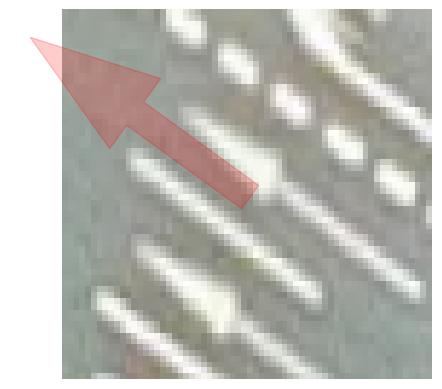

In [ ]:
import random

test_row = test_df.sample(1)
path = "data/flechas/" + test_row.path.values[0]
img_pil = cv.imread(path)
img_pil = cv.cvtColor(img_pil, cv.COLOR_BGR2RGB)
plt.imshow(img_pil)
plt.axis("off")

ground_truth_sin = test_row.sin.values[0]
ground_truth_cos = test_row.cos.values[0]

output = basecnn(preprocess(test_row.path.values[0]).reshape(1, 3, 64, 64).to(device)).to(device)
pred_sin, pred_cos = output[0][0].item(), output[0][1].item()
plt.arrow(32, 32, pred_sin*20, -pred_cos*20, width=5, color="red", alpha=0.2)
plt.plot()

print(f"angulo real: {np.degrees(np.arctan2(ground_truth_sin, ground_truth_cos)) % 360} grados")
print(f"angulo predicho: {np.degrees(np.arctan2(pred_sin, pred_cos)) % 360} grados")
print(f"error: {non_diferientable_loss((ground_truth_sin, ground_truth_cos), (pred_sin, pred_cos))} grados")

In [160]:
sum([param.numel() for param in basecnn.parameters()])

548482

# Pruebas con transfer learning:

importamos vgg16, que es un modelo creado para clasificacion de imagenes con 10 clases.

In [161]:
from torchvision.models import vgg16

my_vgg16 = vgg16(weights='IMAGENET1K_V1').to(device)


print("\nImprimimos todas las capas")
print(my_vgg16)


Imprimimos todas las capas
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, str

comprobamos que la red tiene 3 modulos:

- una secuencia de convoluciones.
- una que aplana.
- una secuencia lineal.

### Congelamos los pesos de la secuencia de convoluciones.

In [162]:
for param in my_vgg16.features.parameters():
    param.requires_grad = False

### modificamos la capa classifier:



In [163]:
my_vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=2),
 ).to(device)

# aseguramos que la nueva parte también esté en el dispositivo correcto
my_vgg16 = my_vgg16.to(device)

In [164]:
from torchsummary import summary

summary(my_vgg16, (3, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [165]:
resized_train_arrows_ds = ArrowsDS(train_df, size=(224, 224))
resized_test_arrows_ds = ArrowsDS(test_df, size=(224, 224))

resized_train_dl = DataLoader(
    dataset=resized_train_arrows_ds,
    batch_size=8,
    shuffle=True,
)

resized_test_dl = DataLoader(
    dataset=resized_test_arrows_ds,
    batch_size=8,
    shuffle=True,
)

In [166]:
loss = nn.MSELoss()
optimicer = torch.optim.Adam(my_vgg16.parameters(), lr=0.0001)

train(my_vgg16, resized_train_dl, resized_test_dl, loss, optimicer, epochs=10)

Epoch: 0 - iteracion: 500
Loss Train: 0.26041179895401 - Test error: 40.90017318725586 grados
Epoch: 1 - iteracion: 1000
Loss Train: 0.1763681322336197 - Test error: 30.751256942749023 grados
Epoch: 1 - iteracion: 1500
Loss Train: 0.2139834761619568 - Test error: 30.16716766357422 grados
Epoch: 2 - iteracion: 2000
Loss Train: 0.05435390770435333 - Test error: 26.005361557006836 grados
Epoch: 3 - iteracion: 2500
Loss Train: 0.06560075283050537 - Test error: 26.72527503967285 grados
Epoch: 3 - iteracion: 3000
Loss Train: 0.04737469181418419 - Test error: 24.488121032714844 grados
Epoch: 4 - iteracion: 3500
Loss Train: 0.12086975574493408 - Test error: 26.13355255126953 grados
Epoch: 5 - iteracion: 4000
Loss Train: 0.10848097503185272 - Test error: 25.325220108032227 grados
Epoch: 5 - iteracion: 4500
Loss Train: 0.030301732942461967 - Test error: 25.795326232910156 grados
Epoch: 6 - iteracion: 5000
Loss Train: 0.046494439244270325 - Test error: 24.87476348876953 grados
Epoch: 7 - iteracio

In [170]:
torch.save(my_vgg16.state_dict(), "vgg16_flechas.pth")
torch.save(basecnn.state_dict(), "basecnn_flechas.pth")